In [1]:
import os
import csv
import cv2
import math
import pickle
import numpy as np
from keras import optimizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.utils import shuffle
from keras.models import load_model
from keras.preprocessing import image
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Flatten, Dense, Activation, Dropout, Lambda, Cropping2D, Convolution2D

Using TensorFlow backend.


In [ ]:
# 'steering', 'throttle', 'brake', 'speed'

In [2]:
def generate_labels_track1(root="./data/data/"):
    labels = []
    with open(root+"driving_log.csv") as file:
        for row in csv.reader(file):
            labels.append(row)
    labels = labels[1:]
    return labels

In [3]:
def generate_labels_track2(root="./data2/"):
    labels = []
    with open(root+"driving_log.csv") as file:
        for row in csv.reader(file):
            temp = []
            for r in row[:3]:
                t = r.split("/IMG/")
                r = t[0] + "/data2/IMG/" + t[1]
                temp.append(r)
            temp.extend(row[3:])
            labels.append(temp)
    labels = labels[300:]
    return labels

In [4]:
labels = generate_labels_track1()

In [5]:
labels2 = generate_labels_track2()

In [6]:
def data_generator(labels, root="./data/data/IMG/", batch_size=32, N=1/2, k=0.2):
    
    '''generate batch of data'''
    
    train_size = len(labels)
    while True: # Loop forever so the generator never terminates
        
        labels = shuffle(labels)
        
        for x in range(0, train_size, batch_size):
            batch = labels[x:(x + batch_size)]
            
        images = []
        angles = []
        
        for b in batch:
            
            if np.random.random() < 0.5:
                # central camera
                name = root + b[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_angle = float(b[3])
                images.append(center_image)
                angles.append(center_angle)
            else:
                # flip central camera
                name = root + b[0].split('/')[-1]
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_image = np.fliplr(center_image)
                center_angle = -float(b[3])
                images.append(center_image)
                angles.append(center_angle)
#             else:
#                 # use left and right camera
#                 if np.random.random() < 0.5:
#                     name = root + b[1].split('/')[-1]
#                     left_image = cv2.imread(name)
#                     left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
#                     left_angle = float(b[3]) + k
#                     images.append(left_image)
#                     angles.append(left_angle)
#                 else:
#                     name = root + b[2].split('/')[-1]
#                     right_image = cv2.imread(name)
#                     right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
#                     right_angle = float(b[3]) - k
#                     images.append(right_image)
#                     angles.append(right_angle)
                
            #data augmentation    
            
                
            
        x_train = np.array(images)
        y_train = np.array(angles)
        yield (x_train, y_train)

In [7]:
train_samples, validation_samples = train_test_split(labels, test_size=0.2)

In [8]:
train_generator = data_generator(train_samples)
validation_generator = data_generator(validation_samples)

In [9]:
def Net(input_shape, crop):

    model = Sequential()
    model.add(Cropping2D(cropping=crop, input_shape=input_shape))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5)) 
    model.add(Convolution2D(24, 5, 5, border_mode='valid', subsample=(2,2), activation="relu", init="he_normal"))
    model.add(BatchNormalization())
    model.add(Convolution2D(36, 5, 5, border_mode='valid', subsample=(2,2), activation="relu", init="he_normal"))
    model.add(BatchNormalization())
    model.add(Convolution2D(48, 5, 5, border_mode='valid', subsample=(2,2), activation="relu", init="he_normal"))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(2,2), activation="relu", init="he_normal"))
    model.add(BatchNormalization())
    model.add(Convolution2D(64, 3, 3, border_mode='valid', subsample=(2,2), activation="relu", init="he_normal"))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu', init="he_normal"))
    model.add(BatchNormalization())
    model.add(Dense(50, activation='relu', init="he_normal"))
    model.add(BatchNormalization())
    model.add(Dense(10, activation='relu', init="he_normal"))
    model.add(BatchNormalization())
    model.add(Dense(1))
    
    return model

In [10]:
model = Net((160,320,3), ((50,20), (0,0)))

In [11]:
model.compile(loss='mse', optimizer="adam")

In [12]:
batch_size = 32

In [13]:
train_sample_size = math.ceil(len(train_samples) / batch_size) * batch_size
validation_sample_size = math.ceil(len(validation_samples) / batch_size) * batch_size

In [14]:
try:
    h = model.fit_generator(train_generator, samples_per_epoch=6468, 
                    validation_data=validation_generator, nb_val_samples=validation_sample_size, 
                    nb_epoch=40, verbose=1)
    model.save('NVIDIA_model_drop.h5')
except KeyboardInterrupt:
    model.save('NVIDIA_model_drop.h5') 

Epoch 1/40
6468/6468 [==============================] - 25s - loss: 0.4092 - val_loss: 0.0558
Epoch 2/40
6468/6468 [==============================] - 24s - loss: 0.0549 - val_loss: 0.0261
Epoch 3/40
6468/6468 [==============================] - 24s - loss: 0.0308 - val_loss: 0.0215
Epoch 4/40
6468/6468 [==============================] - 24s - loss: 0.0245 - val_loss: 0.0147
Epoch 5/40
6468/6468 [==============================] - 24s - loss: 0.0205 - val_loss: 0.0133
Epoch 6/40
6468/6468 [==============================] - 24s - loss: 0.0189 - val_loss: 0.0137
Epoch 7/40
6468/6468 [==============================] - 24s - loss: 0.0166 - val_loss: 0.0109
Epoch 8/40
6468/6468 [==============================] - 24s - loss: 0.0156 - val_loss: 0.0135
Epoch 9/40
6468/6468 [==============================] - 24s - loss: 0.0150 - val_loss: 0.0116
Epoch 10/40
6468/6468 [==============================] - 24s - loss: 0.0141 - val_loss: 0.0116
Epoch 11/40
6468/6468 [==============================] - 24

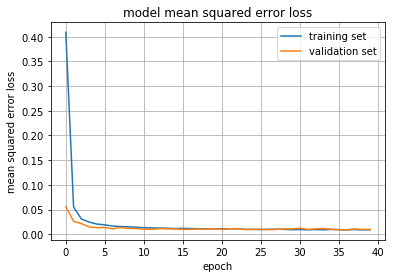

In [15]:
### plot the training and validation loss for each epoch
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.grid()
plt.show()

In [16]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 90, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
batchnormalization_1 (BatchNorma (None, 43, 158, 24)   96          convolution2d_1[0][0]            
___________________________________________________________________________________________